In [0]:
import glob
import os
from PIL import Image
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Homework 2, part 1

## transfer learning
1. below you will find the dataset object for the galaxy dataset from homework 1, except that now it outputs a 69x69 image (no flattening), and the single grayscale channel is repeated 3 times to give a 3x69x69 image

2. load a pre-trained network from pytorchs selection https://pytorch.org/docs/stable/torchvision/models.html

3. create a network to classify the galaxy image dataset with some parts from the pretrained network

4. train the new network

5. when you reach over 75% accuracy on the validation dataset, submit your trained model (state_dict and source code)

6. double check that if you train the same model without the pre-trained weights, it will perform worse (no need to submit this model) 

In [0]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )

In [0]:
import zipfile
import io
dir_path = 'drive/My Drive/Colab Notebooks/HW2'
data = zipfile.ZipFile(io.BytesIO(os.path.join(dir_path, 'Dataset.zip')), 'r')
data.extractall()

path_to_training_data = 'Dataset/train/'
path_to_validation_data = 'Dataset/validation/'

In [0]:
import glob
from PIL import Image
from PIL import ImageFilter
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


class CustomDataset(Dataset):
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10,transform=False):
        
        self.mean = mean
        self.std = std
        
        self.do_transform = transform
        self.transform = transforms.RandomRotation(180)
        
        self.filelist = glob.glob(path+'/*.png')
        
        self.labels = np.zeros(len(self.filelist))
        
        for class_i in range(n_classes):
            self.labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
        self.labels = torch.LongTensor(self.labels)
      
        self.imgs = []
        for fname in self.filelist:
            img = Image.open(fname)
            self.imgs.append(img)
  
    def __len__(self):
       
        return len(self.filelist)

    def __getitem__(self, idx):
        
        img = self.imgs[idx]
    
        if self.do_transform:
            
            img = self.transform(img)
        
        
        x = transforms.ToTensor()(img)
        
        x = (x-self.mean)/self.std
        
        x = x.repeat(3,1,1)
        
        
        class_label = self.labels[idx]
        
        return x, class_label

In [0]:
train_ds = CustomDataset(path_to_training_data,transform=False)
valid_ds = CustomDataset(path_to_validation_data,transform=False)

In [0]:
x,y = train_ds[553]

In [9]:
x.shape

torch.Size([3, 69, 69])

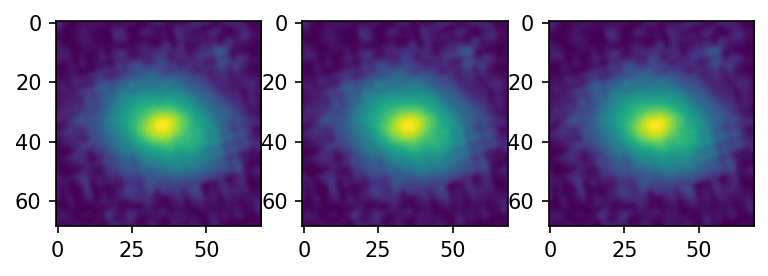

In [10]:
fig,ax = plt.subplots(1,3,figsize=(6,2),dpi=150)

for i in range(3):
    ax[i].imshow(x[i])

In [0]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)
#vgg11 = models.vgg11(pretrained=False)

In [12]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
??vgg16

In [0]:
class ImageClassifier(nn.Module):

    def __init__(self, model):
        super(ImageClassifier, self).__init__()
        
        self.model = model

        #you can take all of the conv layers before the max pooling,
        # self.features = vgg16.features
        
        #or you can take a subset of them
        # self.conv1 = vgg16.features[0]
        # self.conv2 = vgg16.features[3]
        # self.conv3 = vgg16.features[6]
        
        #if you want to use subsets of a sequential model:
        # self.part1 = nn.Sequential(*[vgg16.features[i] for i in range(16)])
        
        # self.classifier = #...
        
    def forward(self, x):
        # out = self.features(x)
        out = self.model(x)
        
        ##### pass through the rest of your model
        
        return out

In [0]:
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)
resnet18 = resnet18.to(device)
model = resnet18

In [0]:
img_classifier = ImageClassifier(model)

In [14]:
import torch.optim as optim #, lr_scheduler

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


NameError: ignored

In [0]:
save_path = 'drive/My Drive/Colab Notebooks/HW2'

In [0]:
import time
import copy 

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), os.path.join(save_path, 'transfer_best_model_resnet_yahel.pt'))

        print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
image_datasets = {'train': train_ds, 'val': valid_ds}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {'train': len(train_ds), 'val': len(valid_ds)}



In [0]:
model_ft = train_model(model, loss_func, optimizer, None,
                       num_epochs=20)

In [0]:
resnet18 = models.resnet18(pretrained=False)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)
resnet18 = resnet18.to(device)

loaded_state_dict = torch.load(os.path.join(save_path, 'transfer_best_model_resnet_yahel.pt'))
# loaded_state_dict
resnet18.load_state_dict(loaded_state_dict)
loaded_model = resnet18
loaded_model.eval()

In [0]:
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    with torch.set_grad_enabled('val' == 'train'):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

                # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

In [0]:
training_ds = CustomDataset(path_to_training_data,transform=False)
validation_ds = CustomDataset(path_to_validation_data)

tranining_tensor = torch.stack([training_ds[i][0] for i in range(len(training_ds)) ]).to(device)
training_labels = training_ds.labels.data.numpy()

validation_tensor = torch.stack([validation_ds[i][0] for i in range(len(validation_ds)) ]).to(device)
validation_labels = validation_ds.labels.data.numpy()

In [0]:
def dataset_accuracy(tensor_dataset,targets,net):
    
    net.eval()
    
    # net.cpu()
    
    output = net(tensor_dataset)
    
    loss = nn.CrossEntropyLoss()(output,torch.LongTensor(targets)) 

    output = output.data.numpy()
    prediction = np.argmax(output,axis=1)

    n_correct = len(np.where(targets==prediction)[0])
    n_total = len(targets)
    
    if torch.cuda.is_available():
        net.cuda()
    return n_correct/n_total, loss.item()

In [0]:
dataset_accuracy(validation_tensor, validation_labels, loaded_model)